In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting.zip
! rm walmart-recruiting-store-sales-forecasting.zip
! unzip features.csv.zip
! rm features.csv.zip
! unzip train.csv.zip
! rm train.csv.zip
! unzip test.csv.zip
! rm test.csv.zip
! unzip sampleSubmission.csv.zip
! rm sampleSubmission.csv.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 25.0 MB/s eta 0:00:00
Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 588MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


## **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

In [4]:
TREAIN_SIZE = 0.7
VAL_SIZE = 0.15

In [13]:
train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values(by='Date')

In [14]:
train_data = train.iloc[:int(TREAIN_SIZE*train.shape[0])]

In [15]:
train_data.shape

(295099, 5)

In [17]:
weekly_sales = train_data.groupby('Date')['Weekly_Sales'].sum()

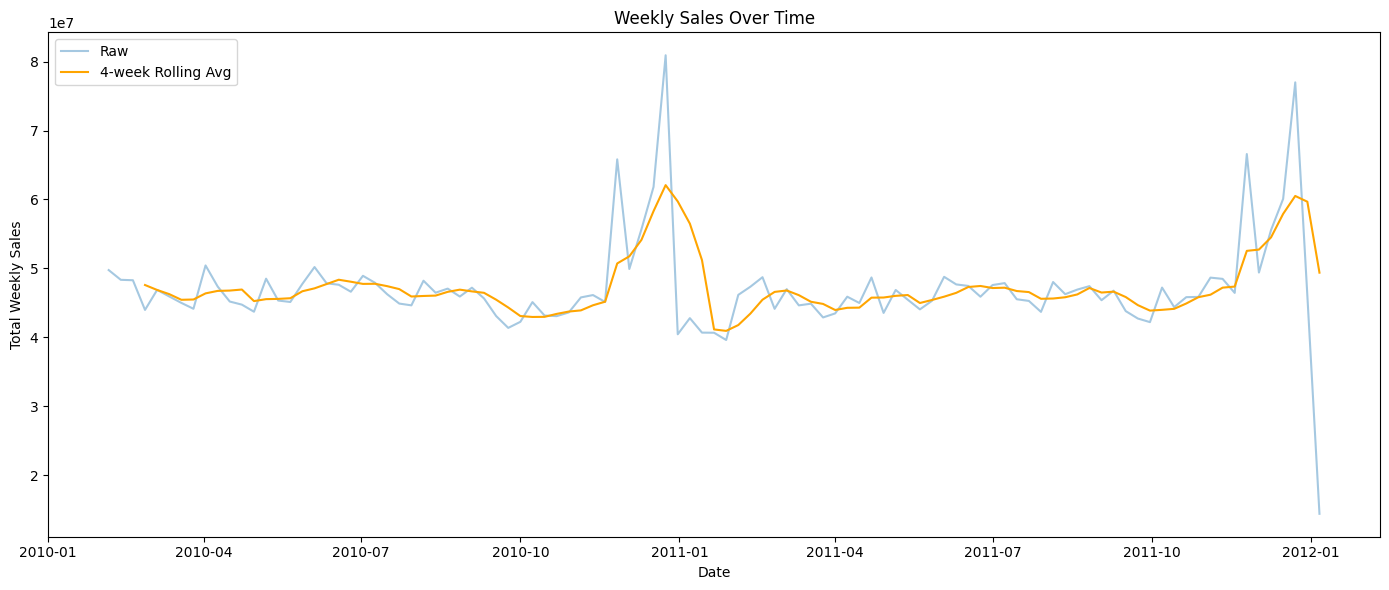

In [20]:
rolling = weekly_sales.rolling(window=4).mean()

plt.figure(figsize=(14, 6))
plt.plot(weekly_sales.index, weekly_sales.values, label='Raw', alpha=0.4)
plt.plot(rolling.index, rolling.values, label='4-week Rolling Avg', color='orange')
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()